In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth',250)
pd.set_option('display.max_rows',50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [2]:
df = pd.read_csv('2019_jb_final.csv')
print(df.shape)
df.rename({'at_time': '_time'}, axis=1, inplace=True)
df.head()

(4156, 20)


,jump_id,jump_name,jump_team,jump_id_2,jump_name_2,jump_team_2,grab_id,grab_name,grab_team,period,_time,game_id,WL,height,weight,height_2,weight_2,question,win_jb,lose_jb
0,201143,Al Horford,BOS,203954,Joel Embiid,PHI,1627732,Ben Simmons,PHI,1,12:00,21800001,W,206.0,109.0,213.0,127.0,False,False,True
1,1627759,Jaylen Brown,BOS,203967,Dario Saric,PHI,201143,Al Horford,BOS,3,10:20,21800001,W,198.0,101.0,208.0,102.0,False,True,False
2,203954,Joel Embiid,PHI,201143,Al Horford,BOS,1627732,Ben Simmons,PHI,1,12:00,21800001,L,213.0,127.0,206.0,109.0,False,True,False
3,203967,Dario Saric,PHI,1627759,Jaylen Brown,BOS,201143,Al Horford,BOS,3,10:20,21800001,L,208.0,102.0,198.0,101.0,False,False,True
4,1627745,Damian Jones,GSW,203500,Steven Adams,OKC,203110,Draymond Green,GSW,1,12:00,21800002,W,211.0,111.0,211.0,120.0,False,True,False


# fill jump ball type

In [3]:
df['jb_type'] = 'other'

one game started at 11:56 https://stats.nba.com/game/0021800010/playbyplay/

In [4]:
df.loc[((df.period == 1) & (df._time.isin(['12:00', '11:56']))), 'jb_type'] = 'start'

In [5]:
df.loc[((df.period > 4) & (df._time == '5:00')), 'jb_type'] = 'ot_start'

In [6]:
df.jb_type.value_counts() // 2

start       1230
other        779
ot_start      69
Name: jb_type, dtype: int64

In [37]:
df[df.question].shape

(152, 21)

# best jumping players

In [7]:
_df = df[~df.question]
print(_df.shape)

(4004, 21)


In [8]:
by_name = _df.groupby('jump_name')['win_jb'].agg(jumps = lambda s: len(s), 
                                                 won = lambda s: np.sum(s > 0),
                                                 won_pct = np.mean)
print(by_name.shape)
by_name.sort_values('jumps', ascending=False, inplace=True)
by_name.head(10)

(377, 3)


,jumps,won,won_pct
jump_name,,,
Steven Adams,100,63,0.630000
Karl-Anthony Towns,98,57,0.581633
Willie Cauley-Stein,95,41,0.431579
Nikola Vucevic,94,44,0.468085
Brook Lopez,91,69,0.758242
Jusuf Nurkic,88,60,0.681818
Jarrett Allen,88,58,0.659091
Marc Gasol,88,45,0.511364
Andre Drummond,86,69,0.802326


In [9]:
by_name.describe()

,jumps,won,won_pct
count,377.000000,377.000000,377.000000
mean,10.620690,5.310345,0.456385
std,19.914896,11.417685,0.341865
min,1.000000,0.000000,0.000000
25%,2.000000,1.000000,0.200000
50%,4.000000,1.000000,0.444444
75%,7.000000,3.000000,0.681818
max,100.000000,69.000000,1.000000


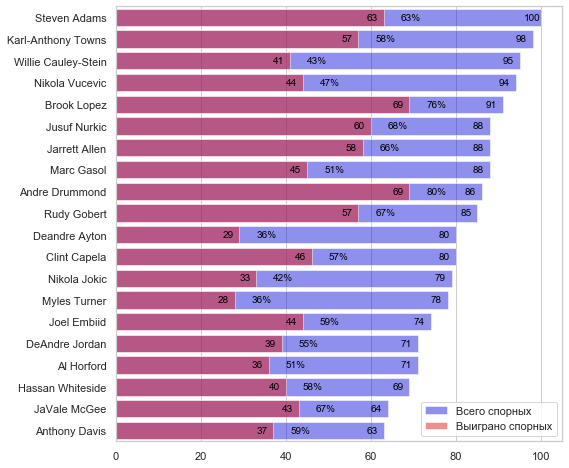

In [10]:
plt.figure(figsize=(8, 8))
def plot_by_name(by_name, ax=None, offset=4, xlab='', ylab='', title='', legend=False):
    ax = sns.barplot(y=by_name.index, x=by_name.jumps, 
                     color='blue', alpha=0.5, label='Всего спорных', ax=ax)
    ax = sns.barplot(y=by_name.index, x=by_name.won, 
                     color='red', alpha=0.5, label='Выиграно спорных', ax=ax)
    for _name, row in by_name.iterrows():
        idx = list(by_name.index).index(_name)
        ax.text(row.jumps - offset, idx, int(row.jumps), color='black', va="center")
        ax.text(row.won - offset, idx, int(row.won), color='black', va="center")
        ax.text(row.won + offset, idx, f"{100 * row.won_pct :.0f}%", color='black', va="center")
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    if legend:
        ax.legend()

plot_by_name(by_name.head(20), legend=True)

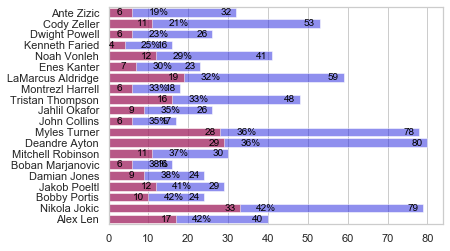

In [11]:
plot_by_name(by_name.query('jumps > 15').sort_values('won_pct').head(20))

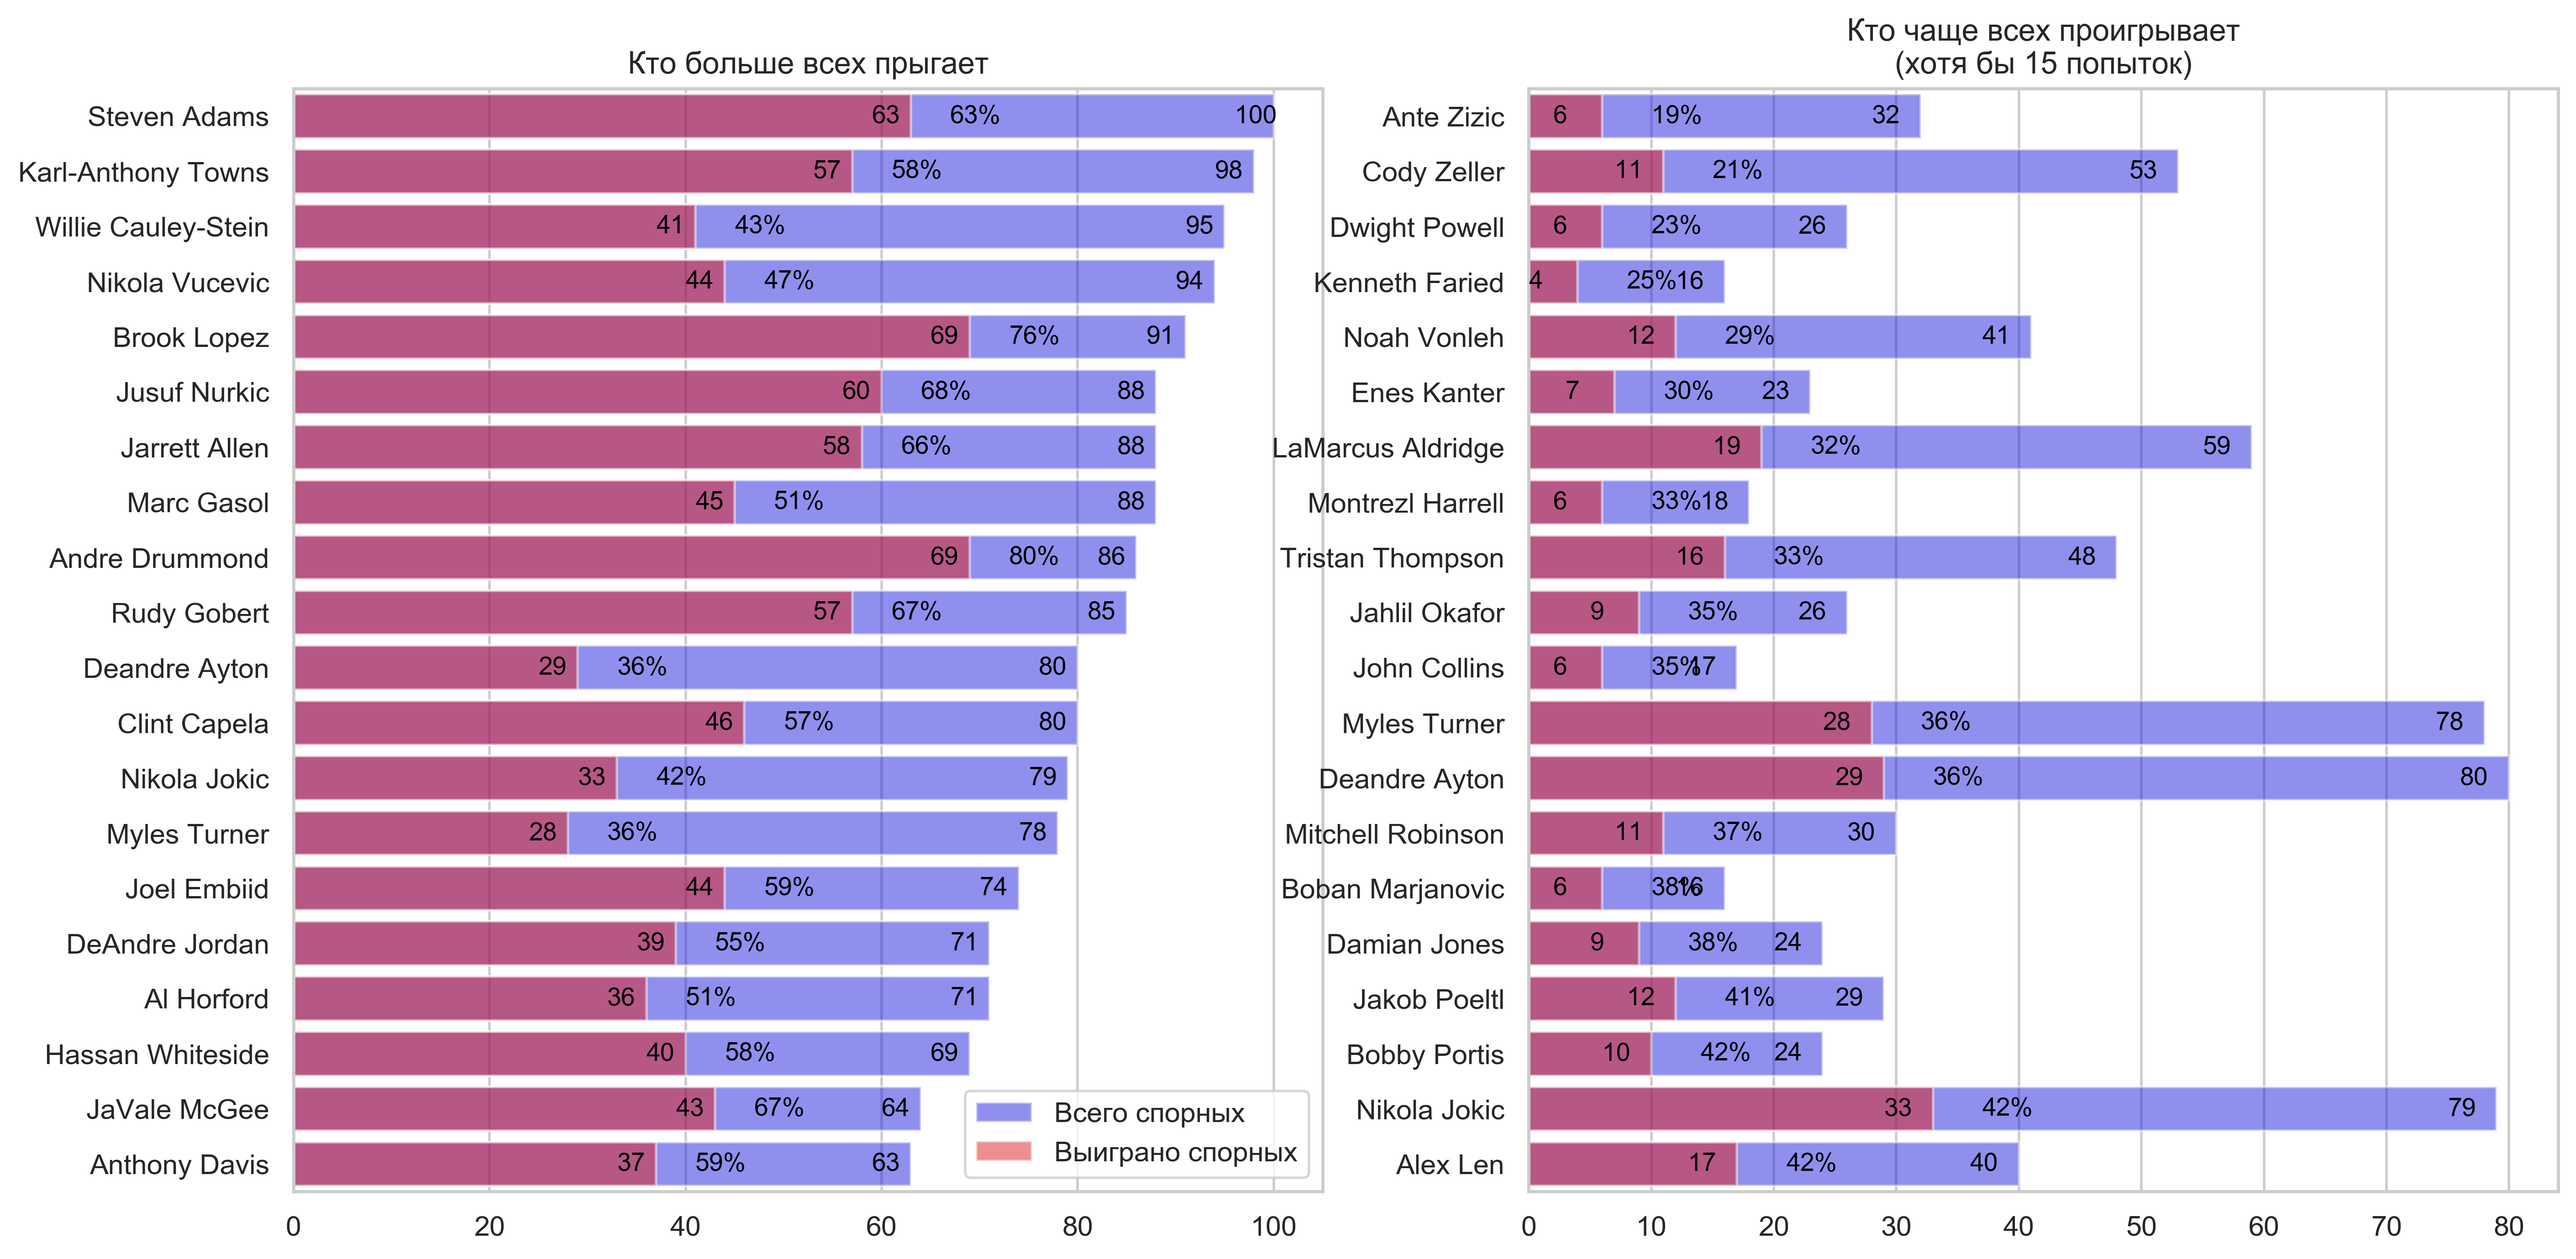

In [12]:
fig, axes = plt.subplots(1, 2, dpi=400, figsize=(16, 8))
plot_by_name(by_name.head(20), ax=axes[0], title='Кто больше всех прыгает', legend=True)
plot_by_name(by_name.query('jumps > 15').sort_values('won_pct').head(20), 
             ax=axes[1], title='Кто чаще всех проигрывает\n(хотя бы 15 попыток)')
fig.savefig('by_name.png')

# game win\loss

In [13]:
from sklearn.metrics import confusion_matrix
tt = _df.query('jb_type == "start"')
print(len(tt))
cm = confusion_matrix(tt.win_jb.astype(np.uint), (tt.WL == 'W').astype(np.uint))
cm

2442


array([[649, 572],
       [572, 649]])

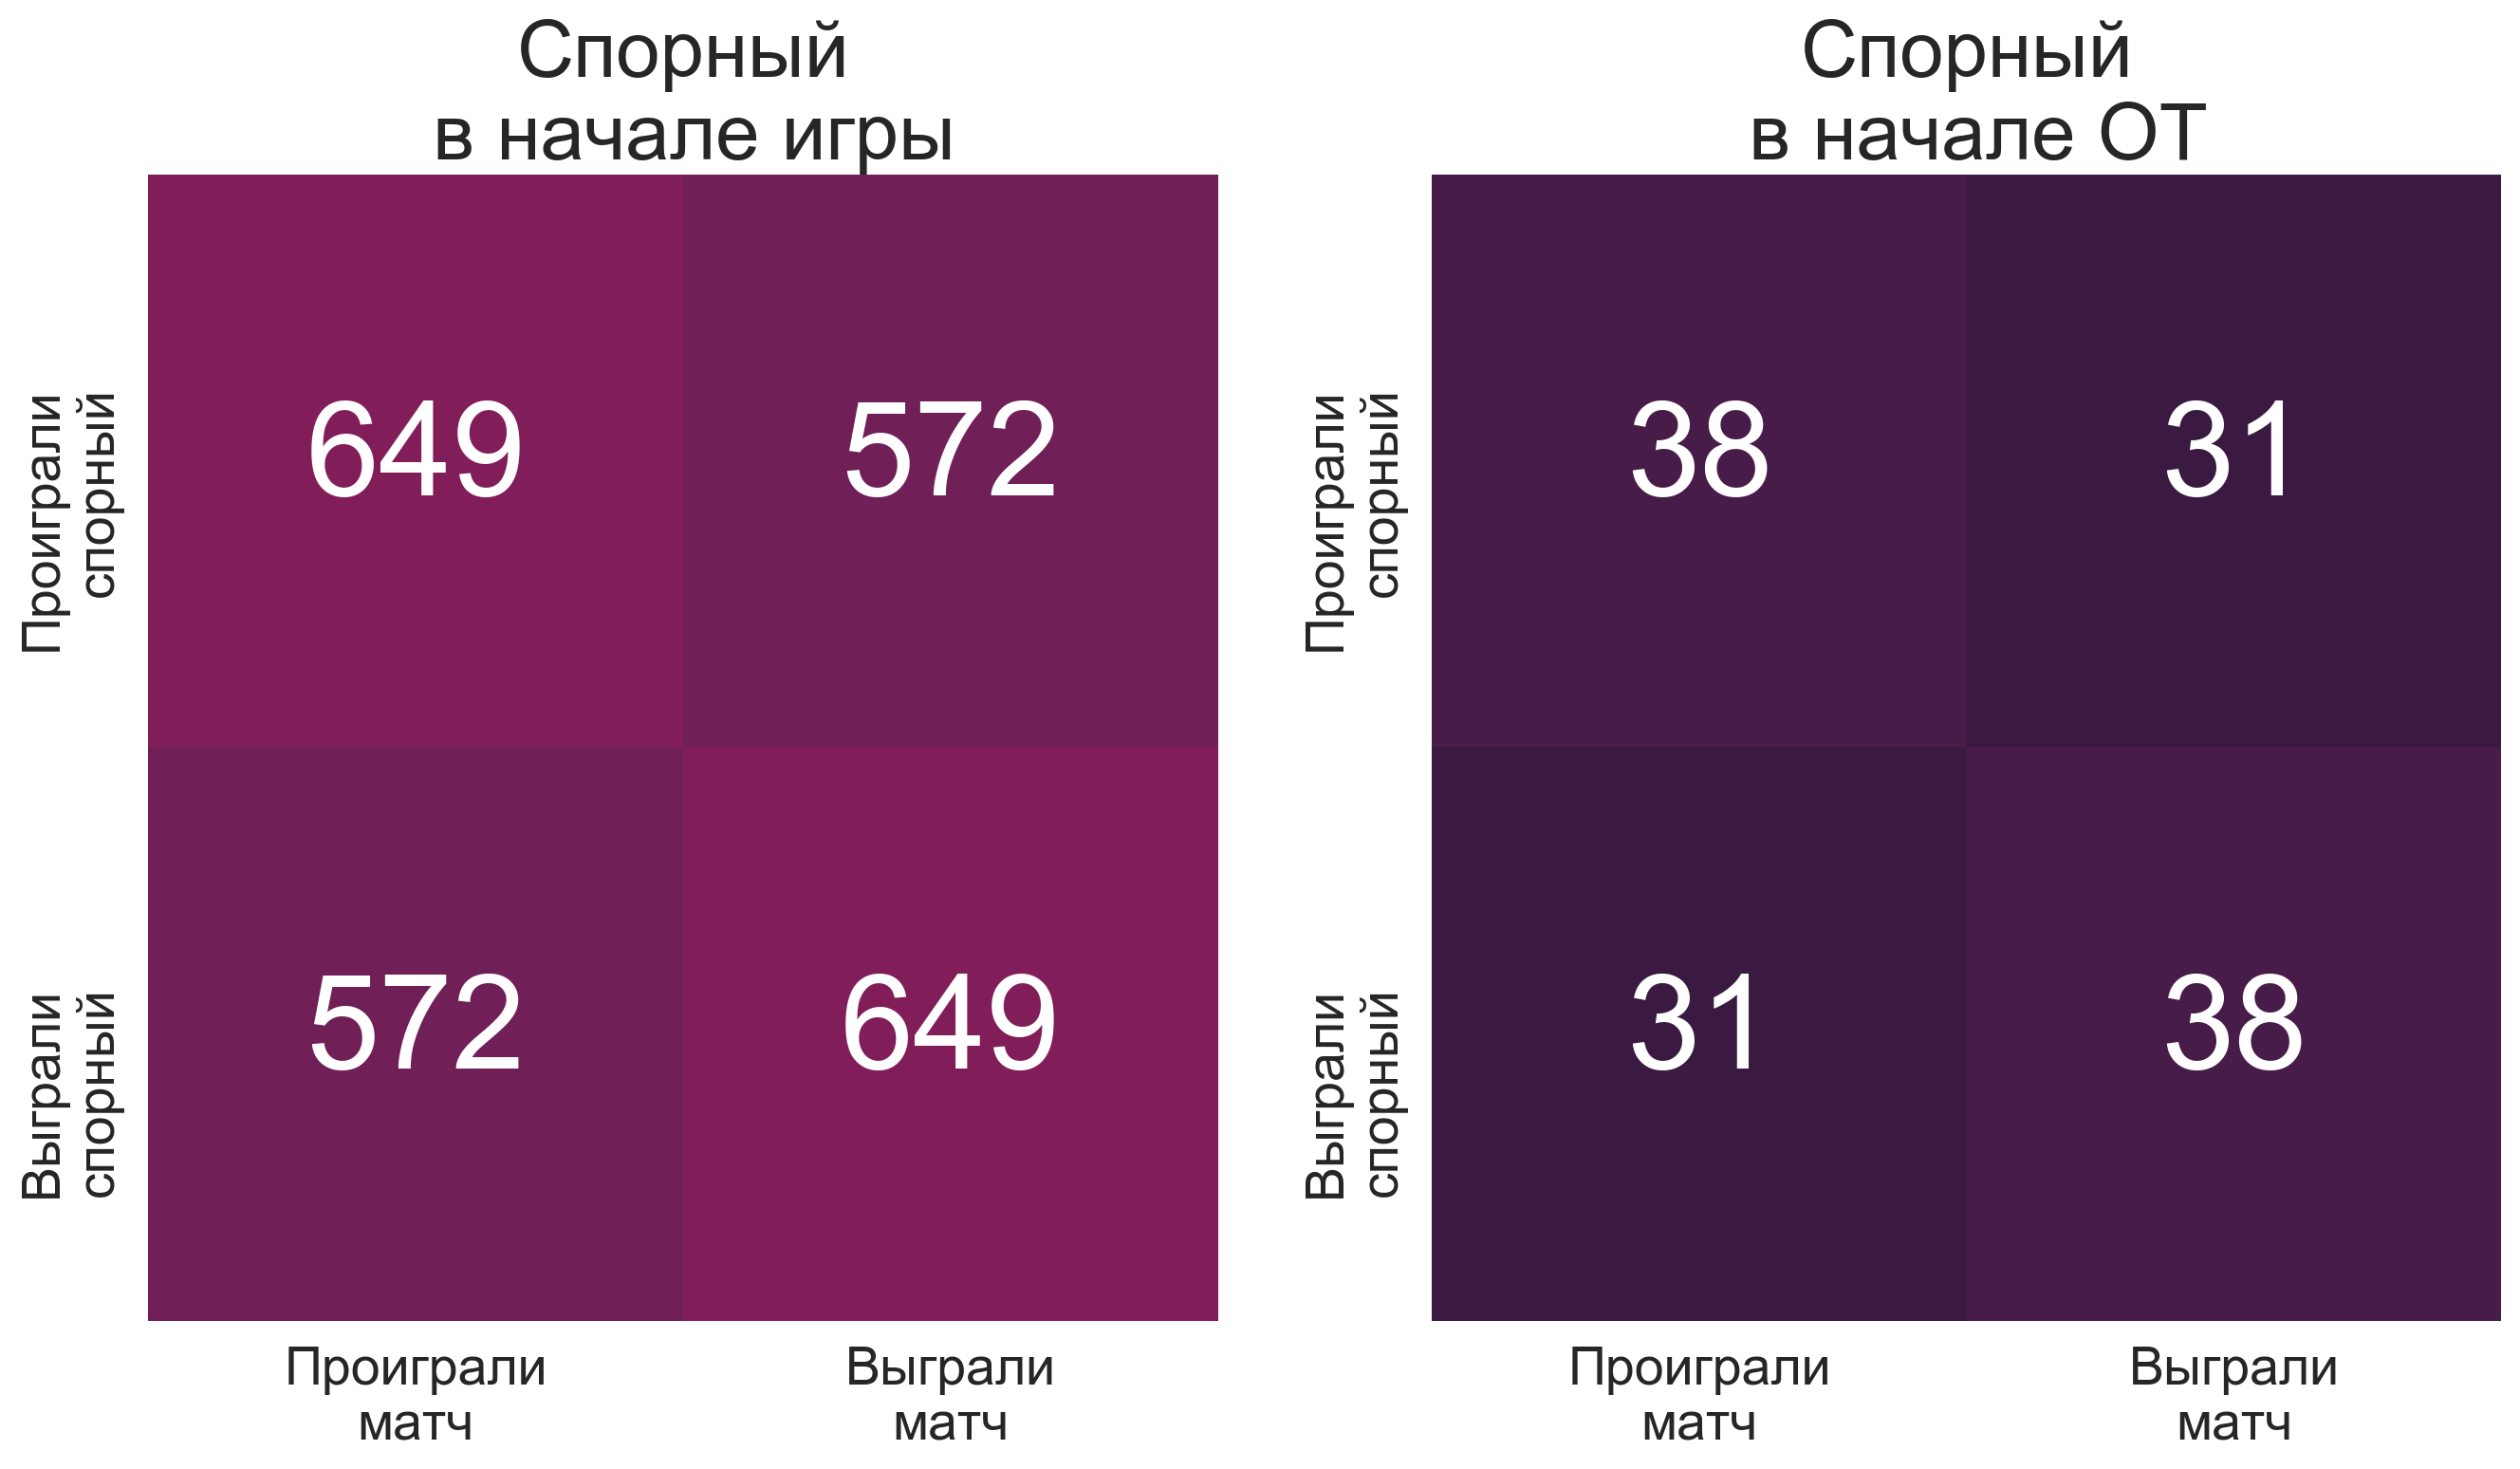

In [14]:
def plot_confmat(cm, ax=None, title='', vmax=2000):
    ax = sns.heatmap(cm, annot=True, cbar=False, fmt='d', ax=ax,
                     vmin=0, vmax=vmax, annot_kws={'size': 50, 'va':"center"})
    ax.set_yticks([0.6, 1.6])
    ax.set_ylim([2.0, 0.])
    ax.set_yticklabels(['Проиграли\nспорный', 'Выграли\nспорный'], fontdict={'fontsize': 20,
                                                                             'verticalalignment': 'center',
                                                                             'horizontalalignment': 'right'})
    ax.set_xticklabels(['Проиграли\nматч', 'Выграли\nматч'], fontdict={'fontsize': 20,
                                                                             'verticalalignment': 'top',
                                                                             'horizontalalignment': 'center'})
    ax.set_title(title, fontdict={'fontsize': 30})

_start_df = _df.query('jb_type == "start"')
start_cm = confusion_matrix(_start_df.win_jb.astype(np.uint), (_start_df.WL == 'W').astype(np.uint))

_ot_df = _df.query('jb_type == "ot_start"')
ot_cm = confusion_matrix(_ot_df.win_jb.astype(np.uint), (_ot_df.WL == 'W').astype(np.uint))

fig, axes = plt.subplots(1, 2, dpi=200, figsize=(16, 8))

plot_confmat(start_cm, ax=axes[0], title='Спорный\n в начале игры')
plot_confmat(ot_cm, ax=axes[1], title='Спорный\n в начале ОТ', vmax=200)

fig.savefig('confmat.png')

# height difference

In [15]:
_df_h = _df[(_df.height_2.notnull() & _df.height.notnull())].copy()
_df_h['height_diff'] = _df_h.height - _df_h.height_2
_df_h['weight_diff'] = _df_h.weight - _df_h.weight_2
print(_df_h.shape)
by_height = (_df_h.groupby('height_diff')['win_jb'].mean() *100).to_frame().reset_index()
by_height.head()

(3796, 23)


,height_diff,win_jb
0,-28.0,14.285714
1,-26.0,33.333333
2,-25.0,33.333333
3,-23.0,31.250000
4,-21.0,38.461538


/home/noone/.virtualenvs/env36/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


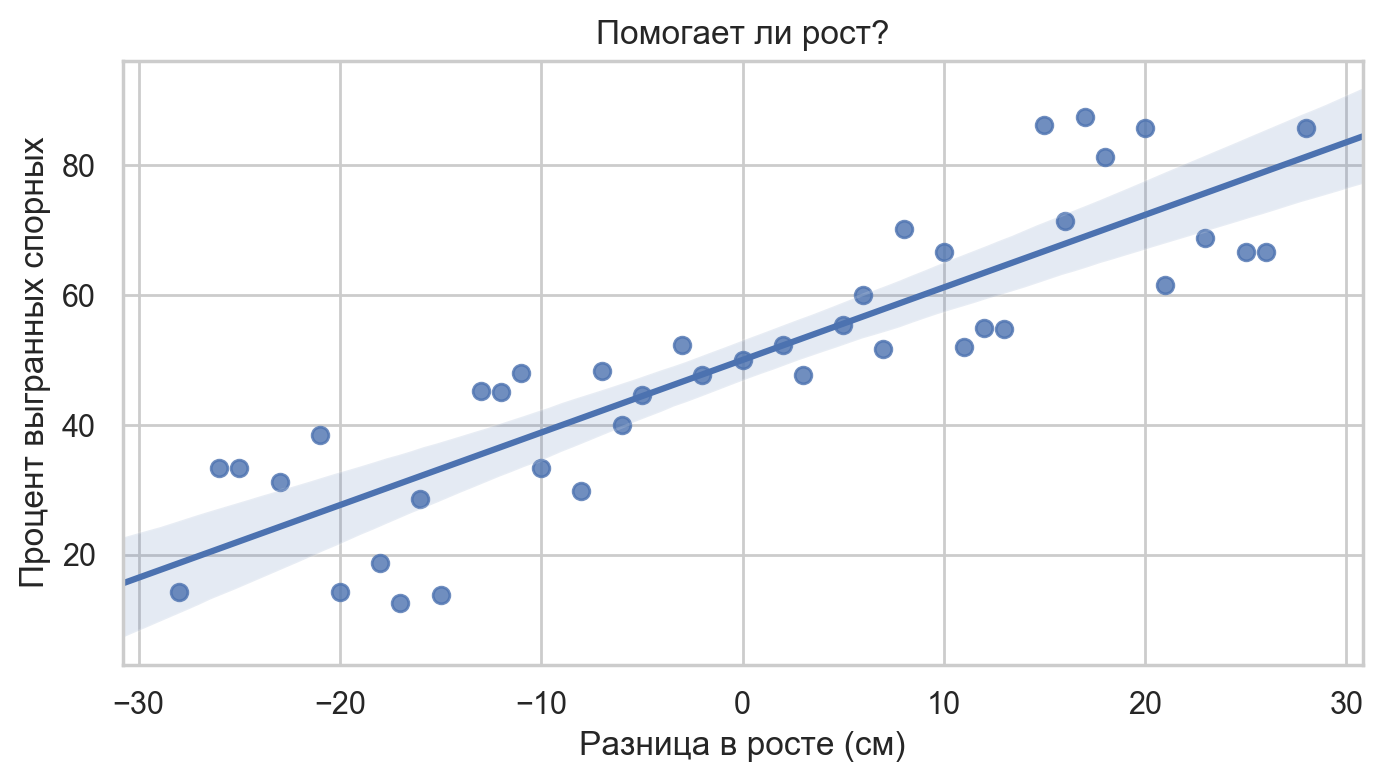

In [16]:
fig, ax = plt.subplots(1, 1, dpi=200, figsize=(8, 4))

sns.regplot(data=by_height, x='height_diff', y='win_jb', ax=ax);
ax.set_xlabel('Разница в росте (см)')
ax.set_ylabel('Процент выгранных спорных')
ax.set_title('Помогает ли рост?')
fig.savefig('by_height.png')

In [17]:
_df_h.loc[_df_h.height_diff.idxmax()]

jump_id              201572
jump_name       Brook Lopez
jump_team               MIL
jump_id_2           1628975
jump_name_2    Jevon Carter
jump_team_2             MEM
grab_id              201588
grab_name       George Hill
grab_team               MIL
period                    2
_time                  6:02
game_id            21800660
WL                        W
height                  213
weight                  128
height_2                185
weight_2                 91
question              False
win_jb                 True
lose_jb               False
jb_type               other
height_diff              28
weight_diff              37
Name: 2233, dtype: object

In [18]:
_df_h.query('win_jb').height_diff.idxmin()

3543

In [19]:
_df_h.loc[3543]

jump_id              202339
jump_name      Eric Bledsoe
jump_team               MIL
jump_id_2            203954
jump_name_2     Joel Embiid
jump_team_2             PHI
grab_id             1628391
grab_name       D.J. Wilson
grab_team               MIL
period                    3
_time                  0:32
game_id            21801043
WL                        L
height                  185
weight                   97
height_2                213
weight_2                127
question              False
win_jb                 True
lose_jb               False
jb_type               other
height_diff             -28
weight_diff             -30
Name: 3543, dtype: object

# best grabbers

In [20]:
_df.groupby('grab_name')['jump_name'].count().sort_values(ascending=False).head(10) // 2

grab_name
Russell Westbrook        50
Giannis Antetokounmpo    48
D'Angelo Russell         44
Ben Simmons              38
P.J. Tucker              37
Blake Griffin            33
Draymond Green           30
Tobias Harris            30
Derrick Favors           30
Taj Gibson               29
Name: jump_name, dtype: int64

In [21]:
_df.query('grab_name == "Russell Westbrook" and jump_team == "OKC"').groupby('jump_name')['jump_name'].count()

jump_name
Dennis Schroder       2
Jerami Grant          7
Nerlens Noel          1
Russell Westbrook     1
Steven Adams         39
Name: jump_name, dtype: int64

In [22]:
_df.query('jump_name == grab_name')

,jump_id,jump_name,jump_team,jump_id_2,jump_name_2,jump_team_2,grab_id,grab_name,grab_team,period,_time,game_id,WL,height,weight,height_2,weight_2,question,win_jb,lose_jb,jb_type
113,1628389,Bam Adebayo,MIA,203077,Michael Kidd-Gilchrist,CHA,1628389,Bam Adebayo,MIA,1,3:28,21800030,L,206.0,116.0,198.0,105.0,False,True,False,other
211,1628366,Lonzo Ball,LAL,1629028,Deandre Ayton,PHX,1628366,Lonzo Ball,LAL,1,12:00,21800060,W,198.0,86.0,211.0,113.0,False,True,False,start
311,203524,Solomon Hill,NOP,203999,Nikola Jokic,DEN,203524,Solomon Hill,NOP,1,12:00,21800095,L,198.0,103.0,213.0,129.0,False,True,False,start
393,1627789,Timothe Luwawu-Cabarrot,OKC,203085,Austin Rivers,WAS,1627789,Timothe Luwawu-Cabarrot,OKC,4,1:03,21800119,W,201.0,100.0,190.0,91.0,False,True,False,other
781,203382,Aron Baynes,BOS,203109,Jae Crowder,UTA,203382,Aron Baynes,BOS,3,4:21,21800229,L,208.0,118.0,198.0,107.0,False,True,False,other
955,202355,Hassan Whiteside,MIA,1628976,Wendell Carter Jr.,CHI,202355,Hassan Whiteside,MIA,1,12:00,21800273,W,213.0,120.0,206.0,122.0,False,True,False,start
1038,201143,Al Horford,BOS,203076,Anthony Davis,NOP,201143,Al Horford,BOS,1,10:35,21800298,W,206.0,109.0,208.0,115.0,False,True,False,other
1163,201954,Darren Collison,IND,1627741,Buddy Hield,SAC,201954,Darren Collison,IND,4,0:01,21800336,L,183.0,79.0,193.0,100.0,False,True,False,other
1374,1626158,Richaun Holmes,PHX,201976,Patrick Beverley,LAC,1626158,Richaun Holmes,PHX,4,8:29,21800399,L,208.0,107.0,185.0,82.0,False,True,False,other
1532,202331,Paul George,OKC,1626171,Bobby Portis,CHI,202331,Paul George,OKC,3,2:19,21800447,W,203.0,100.0,208.0,113.0,False,True,False,other


https://stats.nba.com/events/?flag=1&GameID=0021800060&GameEventID=4&Season=2018-19&title=Jump%20Ball%20Ayton%20vs.%20Ball:%20Tip%20to%20Ball&sct=plot

# best non starters

In [23]:
_df_ns = _df.query('jb_type == "other"')
print(_df_ns.shape)

(1424, 21)


In [24]:
by_name_ns = _df_ns.groupby('jump_name')['win_jb'].agg(jumps = lambda s: len(s), 
                                                 won = lambda s: np.sum(s > 0),
                                                 won_pct = np.mean)
print(by_name_ns.shape)
by_name_ns.sort_values('jumps', ascending=False, inplace=True)
by_name_ns.head(10)

(366, 3)


,jumps,won,won_pct
jump_name,,,
Giannis Antetokounmpo,30,26,0.866667
Jerami Grant,18,11,0.611111
Karl-Anthony Towns,17,9,0.529412
Jaren Jackson Jr.,17,8,0.470588
Hassan Whiteside,17,14,0.823529
Steven Adams,16,11,0.687500
Willie Cauley-Stein,14,7,0.500000
Nikola Jokic,13,6,0.461538
Bam Adebayo,13,9,0.692308


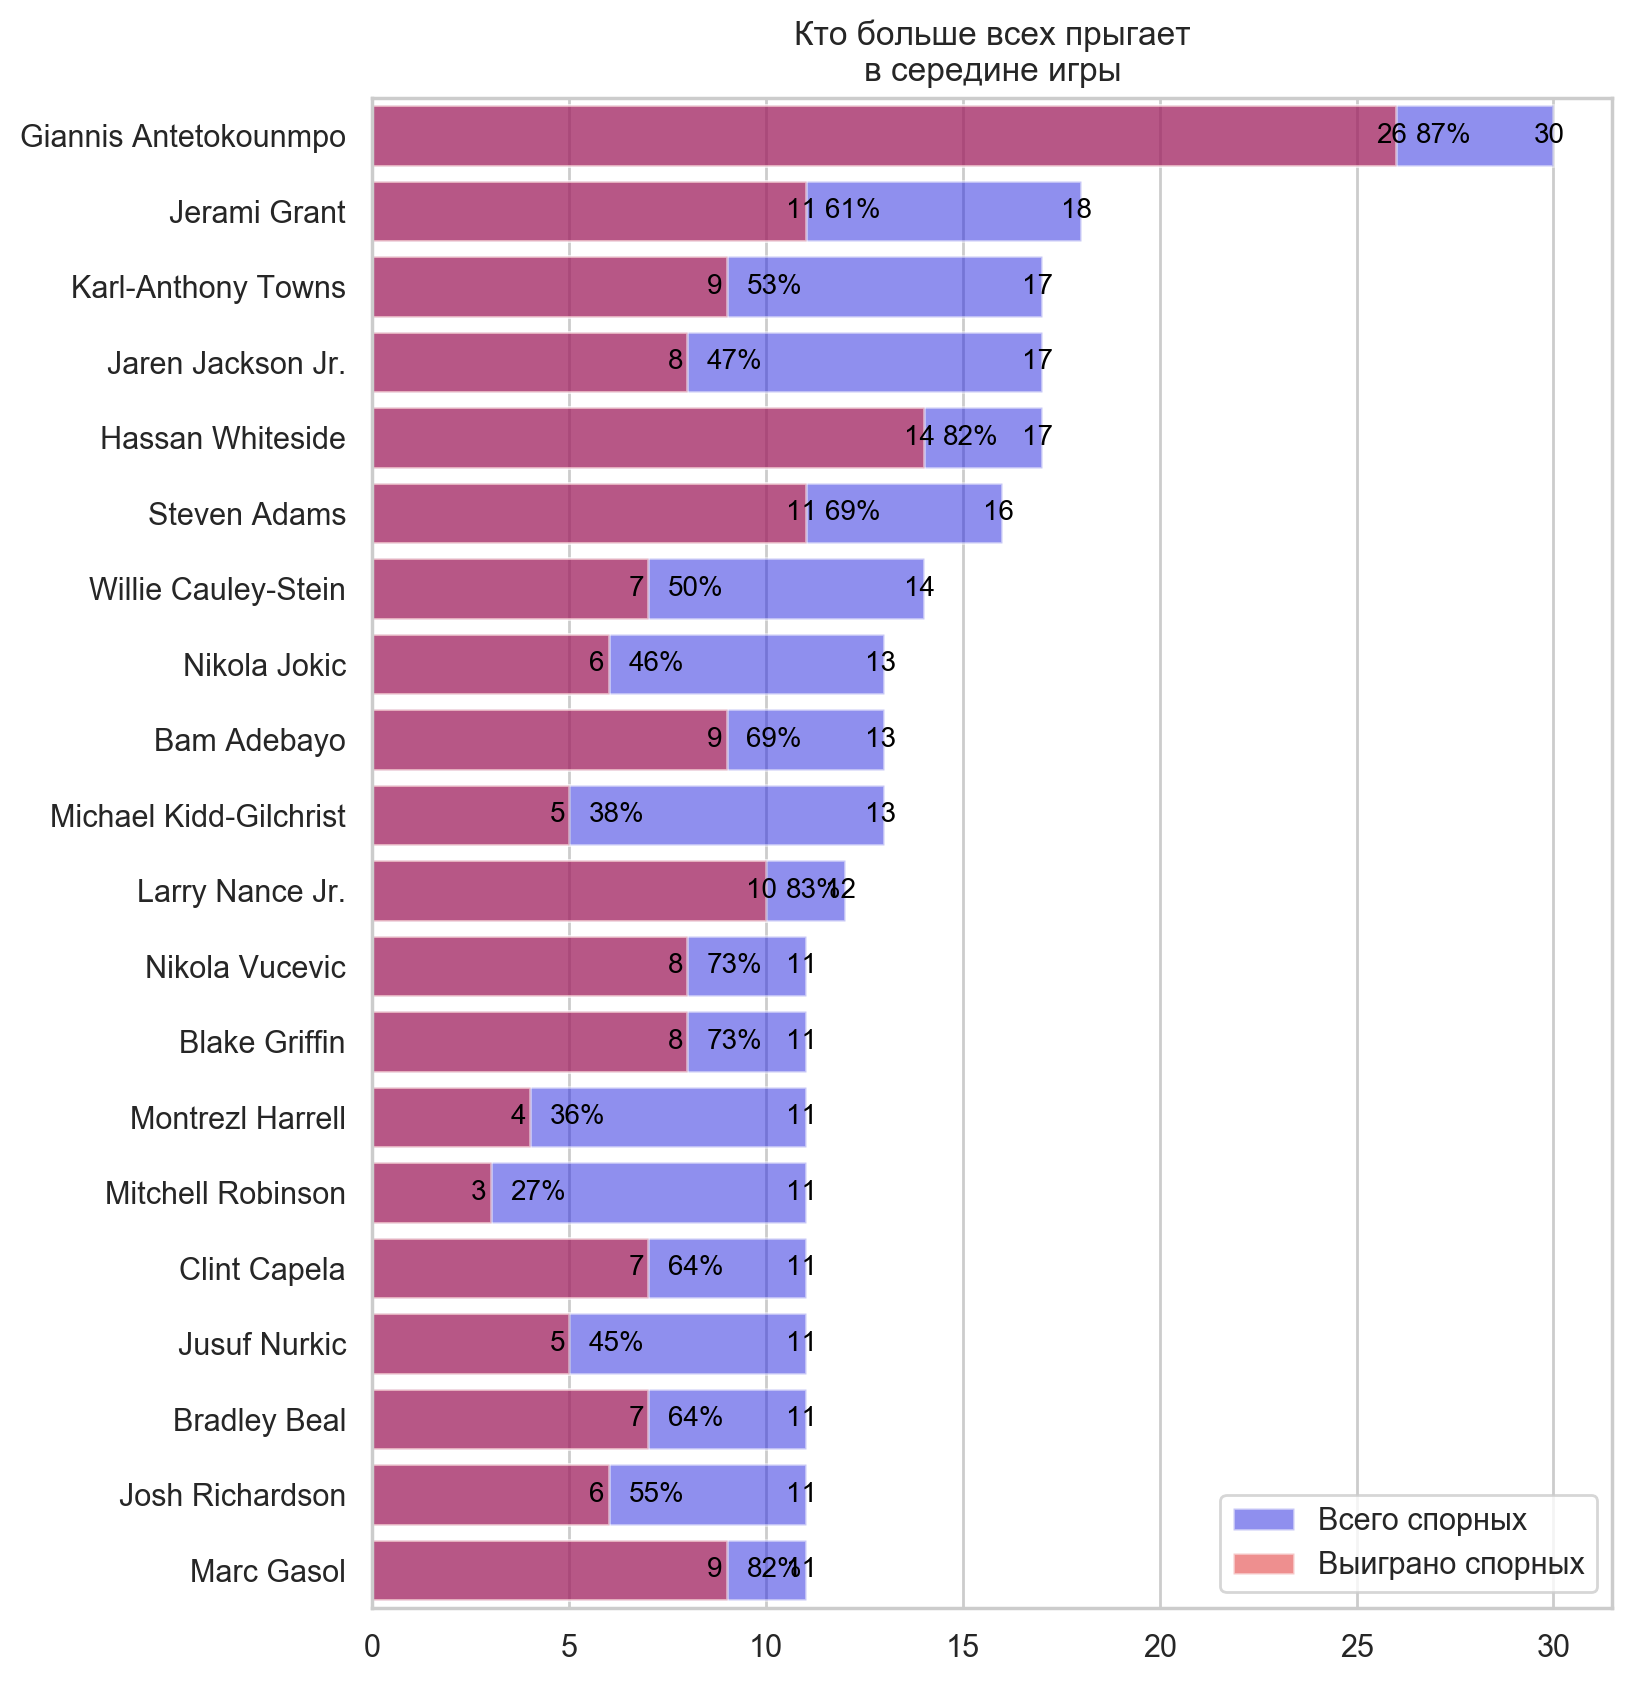

In [25]:
plt.figure(figsize=(8, 10), dpi=200)
plot_by_name(by_name_ns.head(20), legend=True, offset=0.5, title='Кто больше всех прыгает\nв середине игры')
plt.savefig('by_name_nostart.png', bbox_inches='tight')

# non start by quarters

In [26]:
df_ns = df.query('jb_type == "other"')
print(df_ns.shape)

(1558, 21)


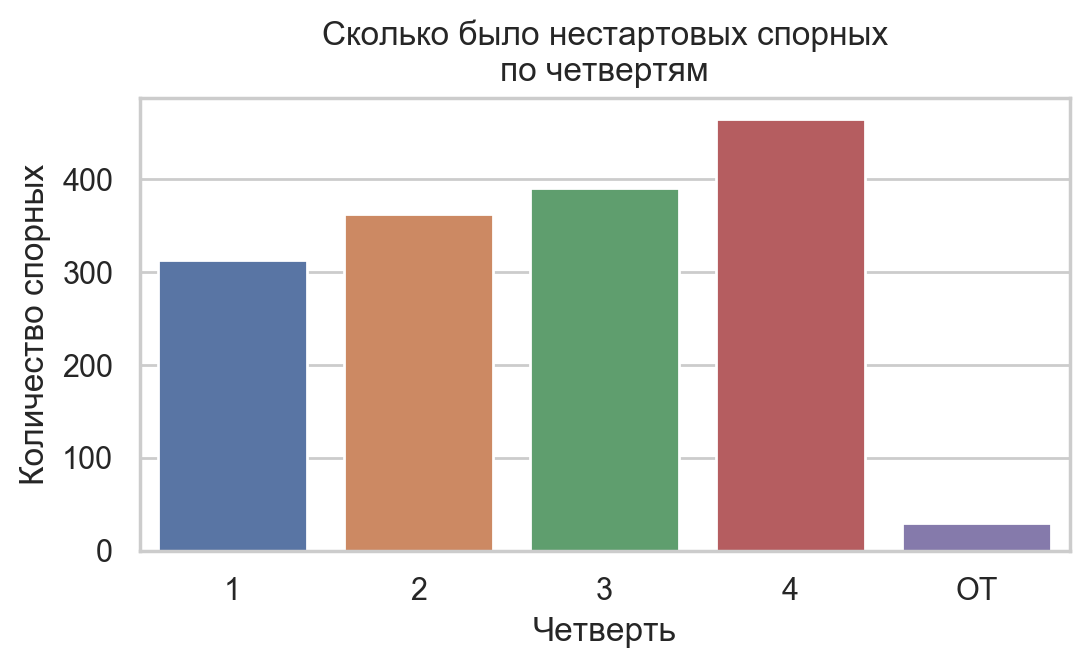

In [27]:
by_period = df_ns.period.map(lambda p: str(p) if p <= 4 else 'OT').value_counts().sort_index()
plt.figure(figsize=(6, 3), dpi=200)
ax = sns.barplot(x=by_period.index, y=by_period)
ax.set_xlabel('Четверть')
ax.set_ylabel('Количество спорных')
ax.set_title('Сколько было нестартовых спорных\nпо четвертям')
plt.savefig('by_period.png', bbox_inches='tight')

# trash

In [28]:
tt = pd.read_csv('2019_games.csv')
print(tt.shape)
tt.head()

(2460, 28)


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22018,1610612763,MEM,Memphis Grizzlies,21801225,2019-04-10,MEM vs. GSW,W,239,132,48,98,0.490,21,46,0.457,15,18,0.833,15,34,49,25,9,0,11,18,15.0
1,22018,1610612753,ORL,Orlando Magic,21801222,2019-04-10,ORL @ CHA,W,240,122,48,88,0.545,11,30,0.367,15,20,0.750,9,30,39,24,5,2,6,19,8.0
2,22018,1610612766,CHA,Charlotte Hornets,21801222,2019-04-10,CHA vs. ORL,L,241,114,41,78,0.526,8,29,0.276,24,27,0.889,4,28,32,21,3,4,8,14,-8.0
3,22018,1610612760,OKC,Oklahoma City Thunder,21801226,2019-04-10,OKC @ MIL,W,240,127,48,99,0.485,23,54,0.426,8,13,0.615,9,44,53,40,7,3,12,20,11.0
4,22018,1610612752,NYK,New York Knicks,21801223,2019-04-10,NYK vs. DET,L,241,89,31,77,0.403,9,30,0.300,18,25,0.720,4,29,33,23,7,5,11,17,-26.0


In [29]:
tt[(tt.MIN > 250)].shape

(134, 28)

In [30]:
53 * 5

265

In [31]:
df.query('game_id == 21800928')

,jump_id,jump_name,jump_team,jump_id_2,jump_name_2,jump_team_2,grab_id,grab_name,grab_team,period,_time,game_id,WL,height,weight,height_2,weight_2,question,win_jb,lose_jb,jb_type
3156,203473,Dewayne Dedmon,ATL,201577,Robin Lopez,CHI,1628374,Lauri Markkanen,CHI,1,12:00,21800928,L,213.0,111.0,213.0,127.0,False,False,True,start
3157,203458,Alex Len,ATL,201577,Robin Lopez,CHI,1713,Vince Carter,ATL,5,5:00,21800928,L,213.0,113.0,213.0,127.0,False,True,False,ot_start
3158,203458,Alex Len,ATL,1628374,Lauri Markkanen,CHI,1629027,Trae Young,ATL,6,5:00,21800928,L,213.0,113.0,213.0,109.0,False,True,False,ot_start
3159,203458,Alex Len,ATL,1628374,Lauri Markkanen,CHI,1713,Vince Carter,ATL,7,5:00,21800928,L,213.0,113.0,213.0,109.0,False,True,False,ot_start
3160,203458,Alex Len,ATL,201577,Robin Lopez,CHI,1713,Vince Carter,ATL,8,5:00,21800928,L,213.0,113.0,213.0,127.0,False,True,False,ot_start
3161,201577,Robin Lopez,CHI,203473,Dewayne Dedmon,ATL,1628374,Lauri Markkanen,CHI,1,12:00,21800928,W,213.0,127.0,213.0,111.0,False,True,False,start
3162,201577,Robin Lopez,CHI,203458,Alex Len,ATL,1713,Vince Carter,ATL,5,5:00,21800928,W,213.0,127.0,213.0,113.0,False,False,True,ot_start
3163,1628374,Lauri Markkanen,CHI,203458,Alex Len,ATL,1629027,Trae Young,ATL,6,5:00,21800928,W,213.0,109.0,213.0,113.0,False,False,True,ot_start
3164,1628374,Lauri Markkanen,CHI,203458,Alex Len,ATL,1713,Vince Carter,ATL,7,5:00,21800928,W,213.0,109.0,213.0,113.0,False,False,True,ot_start
3165,201577,Robin Lopez,CHI,203458,Alex Len,ATL,1713,Vince Carter,ATL,8,5:00,21800928,W,213.0,127.0,213.0,113.0,False,False,True,ot_start


In [32]:
df.query('period > 4')._time.value_counts() // 2

5:00    69
0:01     2
2:42     1
3:41     1
2:47     1
2:02     1
1:05     1
0:22     1
0:18     1
4:41     1
0:33     1
1:48     1
0:30     1
0:25     1
0:31     1
Name: _time, dtype: int64